# Comparison of Observed vs Simulation Data

This notebook presents a comparative analysis between observed temperature data from the city of Konstanz (Markstaette) and simulated temperature data (6-hour aggregate). The primary goal is to assess the correlation and discrepancies between the two datasets, providing insights into the accuracy of the simulation model.

## 1. Import dependencies

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

## 2. Import, modify and optimize data

In [5]:
# Load the observed and simulated temperature data files
obs_file_path = f"./Data/Observation Data Konstanz/_obsMark_14_15.csv"
sim_file_path = f"./Data/_other/markstaette_simulation_230614_agg6.csv"

# Read the CSV files into pandas DataFrames
obs_data_raw = pd.read_csv(obs_file_path)
sim_data_raw = pd.read_csv(sim_file_path)

# Create copies of the raw data for cleaning and manipulation
obs_data = obs_data_raw.copy()
sim_data = sim_data_raw.copy()

# Convert 'Messzeitpunkt' in observed data to datetime objects
obs_data['Messzeitpunkt'] = pd.to_datetime(obs_data['Messzeitpunkt'])

# Convert 'Time (hr)' in simulated data to timedelta objects
sim_data['Time (hr)'] = pd.to_timedelta(sim_data['Time (hr)'] + ':00')

# Align simulated data timestamps with observed data by adding the minimum observed timestamp
base_time = obs_data['Messzeitpunkt'].min()
sim_data['Datetime'] = base_time + sim_data['Time (hr)']

In [6]:
# Select 'Temperatur' and 'Messzeitpunkt' columns from observed data
obs_data_subset = obs_data.iloc[:, [4, 5]].copy()

# Round the 'Messzeitpunkt' to the nearest minute and store as 'DateTime'
obs_data_subset['DateTime'] = pd.to_datetime(obs_data_subset['Messzeitpunkt'], format='%H:%M:%S').dt.floor('min')

def round_to_nearest_10_minutes(dt):
    """
    Rounds a given datetime object to the nearest 10-minute interval.
    """
    minutes = dt.minute
    remainder = minutes % 10
    if remainder == 0:
        return dt
    elif remainder < 5:
        return dt - pd.Timedelta(minutes=remainder)
    else:
        return dt + pd.Timedelta(minutes=(10 - remainder))

# Apply the rounding function to create 'DateTimeRound'
obs_data_subset['DateTimeRound'] = obs_data_subset['DateTime'].apply(round_to_nearest_10_minutes)

# Group by 'DateTimeRound' and calculate the mean 'Temperatur'
obs_data_subset_grouped = obs_data_subset.groupby('DateTimeRound', as_index=False).agg({'Temperatur': 'mean', 'DateTimeRound': 'first'})

# Display the first few rows of the grouped observed data
obs_data_subset_grouped.head()

,Temperatur,DateTimeRound
0,17.40,2023-06-14 00:00:00
1,16.95,2023-06-14 00:10:00
2,16.85,2023-06-14 00:20:00
3,16.70,2023-06-14 00:30:00
4,16.50,2023-06-14 00:40:00


In [7]:
# Select 'Datetime' and 'Mean (BS)' columns from simulated data
sim_data_subset = sim_data.iloc[:,[11,3]].copy()

# Round the 'Datetime' column to the nearest minute
sim_data_subset['DateTimeRound'] = pd.to_datetime(sim_data_subset['Datetime'], format='%H:%M:%S').dt.floor('min')

# Display the first few rows of the processed simulated data
sim_data_subset.head()

,Datetime,Mean (BS),DateTimeRound
0,2023-06-14 00:10:26,21.20,2023-06-14 00:10:00
1,2023-06-14 00:20:26,21.20,2023-06-14 00:20:00
2,2023-06-14 00:30:26,21.09,2023-06-14 00:30:00
3,2023-06-14 00:40:26,21.01,2023-06-14 00:40:00
4,2023-06-14 00:50:26,20.83,2023-06-14 00:50:00


In [8]:
# Merge the observed and simulated datasets on the 'DateTimeRound' column
merged_data = pd.merge(obs_data_subset_grouped, sim_data_subset, on='DateTimeRound', suffixes=('_obs', '_sim'))

# Calculate the standard deviation for the observed temperature
std_obs = merged_data['Temperatur'].std()

# Calculate the standard deviation for the simulated temperature
std_sim = merged_data['Mean (BS)'].std()

# Calculate the Pearson correlation coefficient between observed and simulated temperatures
correlation = merged_data['Temperatur'].corr(merged_data['Mean (BS)'])

# Display the calculated standard deviations and correlation
print(f"Standard Deviation (Observed):, {std_obs:.2f}")
print(f"Standard Deviation (Simulated):, {std_sim:.2f}")
print(f"Correlation: {correlation:.2f}")

Standard Deviation (Observed):, 3.61
Standard Deviation (Simulated):, 3.38
Correlation: 0.93


## 3. Compute and plot correlation

In [9]:
# Create a figure and an axes object for the plot
fig, ax = plt.subplots(figsize=(8, 8), facecolor='w', edgecolor='k')

# Set the title of the plot
ax.set_title('Correlation', fontsize=16, weight='bold')

# Plot observed vs. simulated temperatures as a scatter plot
ax.scatter(merged_data['Temperatur'], merged_data['Mean (BS)'], s=15, marker='o', alpha=0.5, color='blue')

# Add a line of best fit to the scatter plot
m, b = np.polyfit(merged_data['Temperatur'], merged_data['Mean (BS)'], 1)
ax.plot(merged_data['Temperatur'], m*merged_data['Temperatur'] + b, color='red', label='Best Fit Line')

# Set labels for the x and y axes
ax.set_xlabel(f"Observed Temperature (°C)", fontsize=14, weight='bold')
ax.set_ylabel(f"Simulated Temperatures (°C)", fontsize=14, weight='bold')

# Configure grid lines and minor ticks
ax.grid(which='major', axis='both', linestyle='-', linewidth=1, color='#000000', alpha=0.15)
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=12, rotation=0, width=1.5)
ax.tick_params(axis='y', labelsize=12, rotation=0, width=1.5)

# Ensure the aspect ratio is equal to make the correlation visually accurate
ax.set_aspect(1)

# Set the y-axis limits and ticks
ax.set_ylim([17, 29])
ax.set_yticks(np.arange(17, 30, 1))

# Set the x-axis limits and ticks
ax.set_xlim([14, 27])
ax.set_xticks(np.arange(14, 28, 1))

# Add the correlation coefficient as text on the plot
plt.text(0.02, 0.97, f'Correlation: {correlation:.2f}',
         fontsize=14,
         weight='bold',
         transform=plt.gca().transAxes)

plt.close()

## 4. Plot line graph (Obs vs Sim)

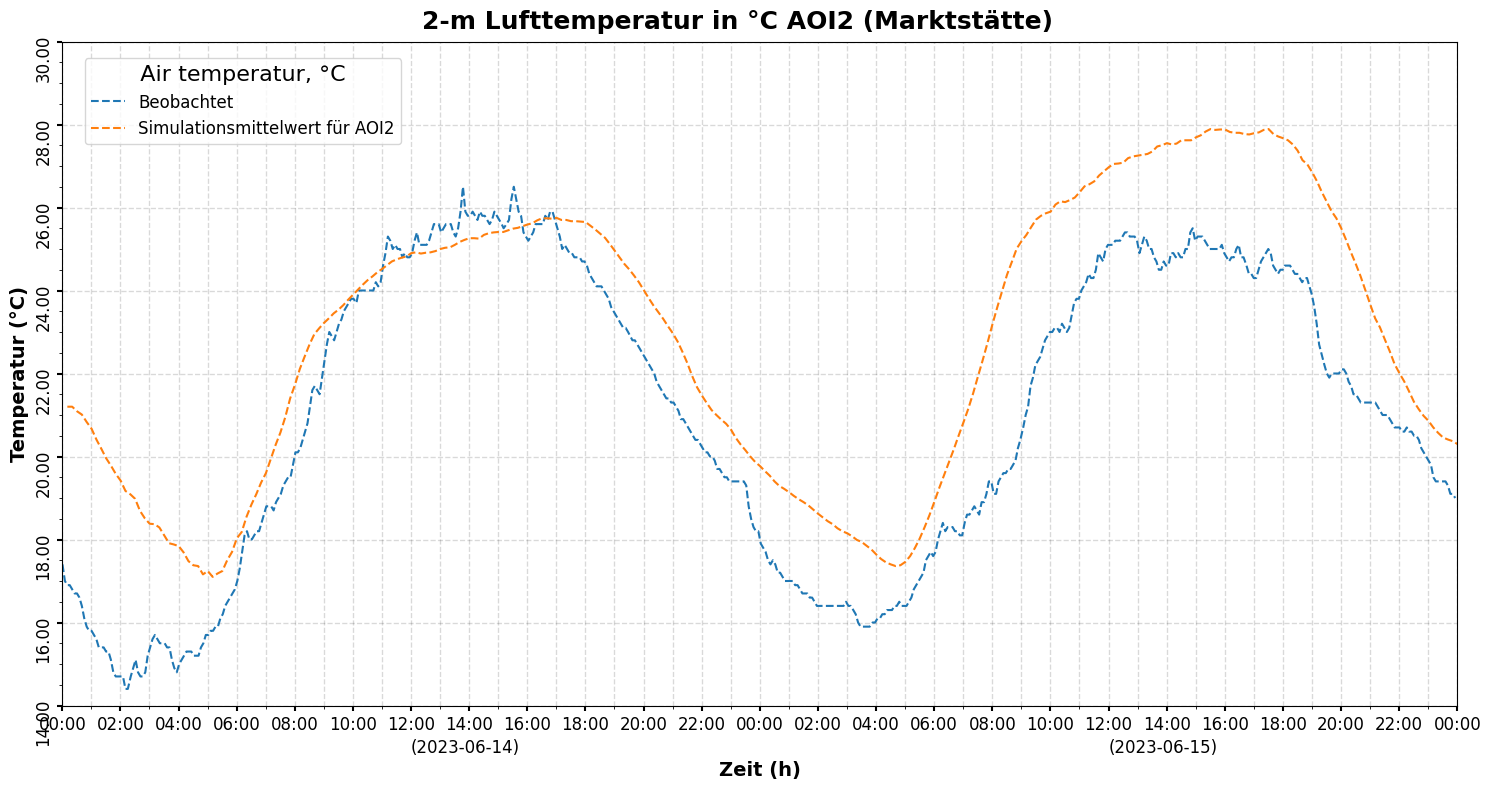

In [10]:
# Create a figure and an axes object for the plot
fig, ax = plt.subplots(figsize=(18, 8), facecolor='w', edgecolor='k')

# Set the main title of the plot
plt.suptitle("2-m Lufttemperatur in °C AOI2 (Marktstätte)", fontsize=18, weight='bold')
plt.subplots_adjust(top=0.94)

# Configure grid lines for better readability
ax.grid(which="major", axis="y", linestyle="--", linewidth=1, color="#00000050", alpha=0.15)
ax.grid(which="both", axis="x", linestyle="--", linewidth=1, color="#00000050", alpha=0.15)

# Enable minor ticks and set tick parameter styles
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=12, rotation=0, width=1.5)
ax.tick_params(axis='y', labelsize=12, rotation=90, width=1.5)

# Format y-axis labels to two decimal places
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.2f}'))

# Format x-axis labels to display only hours and minutes
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Set major and minor ticks for the x-axis to represent hourly intervals
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Major ticks every 2 hours
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every 1 hour

# Set x and y axis labels
ax.set_xlabel(f"Zeit (h)", fontsize=14, weight='bold', labelpad=20)
ax.set_ylabel(f"Temperatur (°C)", fontsize=14, weight='bold')

# Set margins for the plot
ax.margins(0.01)

# Define and set the start and end times for the x-axis to cover the period of interest
start_time = pd.to_datetime('2023-06-14 00:00:00')
end_time = pd.to_datetime('2023-06-16 00:00:00')
ax.set_xlim([start_time, end_time])

# Set the y-axis limits and ticks
ax.set_ylim([14, 30])
ax.set_yticks(np.arange(14, 31, 2))

# Plot the observed temperature data
line1, = ax.plot(obs_data['Messzeitpunkt'], obs_data['Temperatur'], label='Beobachtet', linestyle='--')

# Plot the simulated temperature data
line2, = ax.plot(sim_data['Datetime'], sim_data['Mean (BS)'], label='Simulationsmittelwert für AOI2', linestyle='--')

# Add notes for specific dates on the x-axis
note1 = f"(2023-06-14)"
note2 = f"(2023-06-15)"
ax.text(0.25, -0.05, note1, transform=ax.transAxes, fontsize=12, ha='left', va='top')
ax.text(0.75, -0.05, note2, transform=ax.transAxes, fontsize=12, ha='left', va='top')

# Add a legend to the plot, positioned outside the plot area
ax.legend(title="  Air temperatur, °C  ",
          title_fontsize=16,
          fontsize=12,
          loc="center left",
          bbox_to_anchor=(0.01, 0.91),)

# Display the plot
plt.show()